# JWST Imaging Demo at the Hands On Workshop for JWST+UVIT at CHRIST University, Bangalore, India
## MIRI Imaging Pipeline Notebook
## Adapted from the STScI's JWST Pipeline Notebooks

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15060585.svg)](https://doi.org/10.5281/zenodo.15060585)

### All STScI's curated and maintained JWST Example Notebooks are also available in [this GitHub repository](https://github.com/spacetelescope/jwst-pipeline-notebooks) <br>

**S. Alberts. Based on the original MIRI Imaging Pipeline Example Notebook created by Misty Cracraft (cracraft@stsci.edu), adapted by M. Garcia Marin** <br>
The original notebook is regularly updated as improvements are made to the pipeline. Find the most up to date version of this notebook at: https://github.com/spacetelescope/jwst-pipeline-notebooks/<br>


**Last Updated**: Oct 6, 2025<br>
**Pipeline Version**: 1.19.2 (Build 12.0)

<hr style="border:1px solid gray"> </hr>

## Table of Contents
1. [Introduction](#1.-Introduction)
2. [Configuration](#2.-Configuration)
3. [Package Imports](#3.-Package-Imports)
4. [Directory Setup](#4.-Directory-Setup)
3. [Detector 1 Pipeline](#5.-Detector1-Pipeline)
4. [Image2 Pipeline](#6.-Image2-Pipeline)
5. [Image3 Pipeline](#7.-Image3-Pipeline)
6. [Visualize the data](#8.-Visualize-the-drizzle-combined-image)

## 1. Introduction

**Purpose**:<BR>
This notebook provides a framework for processing JWST Mid-Infrared Instrument (MIRI) 
Imaging data through [stages 1-3 of the James Webb Space Telescope (JWST) pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing#gsc.tab=0), including how to use associations for multi-exposure observations and how to interact and work with JWST [datamodels](https://jwst.readthedocs.io/en/latest/jwst/user_documentation/datamodels.html). Data is assumed to be organized into a folder as provided for this demonstration at CHRIST COSPAR 2025.

**Instrument**:<br>
MIRI provides imaging and spectroscopic observing modes from 4.9 to 27.9 μm. The MIRI imager offers 9 broadband filters covering wavelengths from 5.6 to 25.5 μm over an unobstructed 74" × 113" field of view, and a single 1024×1032 detector plate scale of 0.11 "/pixel (see figes below).

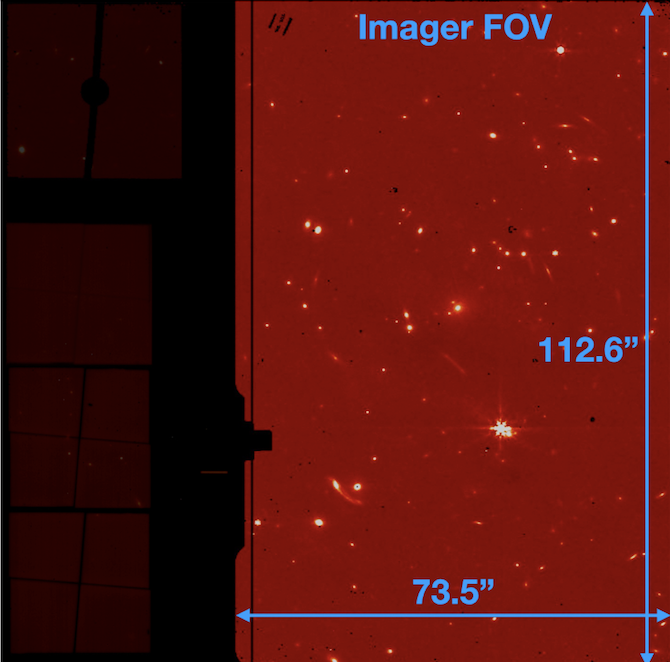

**Data**:<BR>
This notebook is set up to use an example dataset from
[Program ID](https://www.stsci.edu/jwst/science-execution/program-information)
2732 (PI: Pontoppidan) which is an Early Release Observations program in which  Stephan's Quintet, an interactive galaxies system, was observed (see MIRI color image below).

For the purpose of this exercise we focus on the data from Observation 002 Visit 001, with the 
[F770W  filter](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-instrumentation/miri-filters-and-dispersers)
and start with uncalibrated data products. The files are named
`jw02732002001_02101_0000<dither>_mirimage_uncal.fits`, where *dither* refers to the
dither step number. 

More information about the JWST file naming conventions can be found at:
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

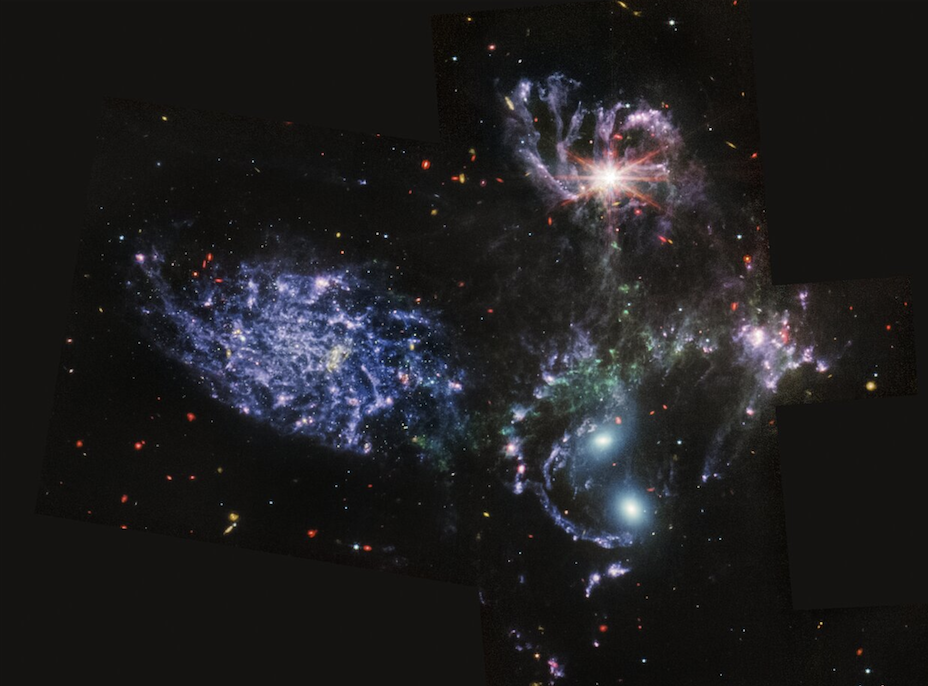

The program setup is briefly summarized in the table below.

| Target: Stephan's Quintet| | |
|:-----------:|:-------:|:---:|
| Proposal ID | 02732 | Program number |
| OBSERVTN | 002 | Observation number |
| [Filters](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-filters#gsc.tab=0) | F770W, F1000W, F1500W| 
| [SUBARRAY](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-observing-modes/miri-imaging#MIRIImaging-MIRISubarraysSubarrays) | FULL | Subarray used |
| [NINTS](https://jwst-docs.stsci.edu/understanding-exposure-times#gsc.tab=0) | 1/1/2 | Number of integrations in exposure/filter|
| NGROUPS | 60/60/80 | Number of groups in integration/filter |
|   DURATION  | 149.464/805.258 [s], depending on filters | Total duration of one exposure |
|   [READPATT](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-instrumentation/miri-detector-overview/miri-detector-readout-overview#gsc.tab=0)  | FASTR1| Readout Pattern |
|   [PATTTYPE](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-operations/miri-dithering/miri-imaging-dithering#gsc.tab=0)  | Cycling LARGE | Dither pattern type |
|   NUMDTHPT  | 8      |  Total number of points in dither pattern|

**[JWST pipeline version and CRDS context](#Set-CRDS-Context-and-Server)**:<br>
This notebook was written for the above-specified pipeline version and associated build context for this version of the JWST Calibration Pipeline. Information about this and other contexts can be found in the JWST Calibration Reference Data System (CRDS [server](https://jwst-crds.stsci.edu/)). If you use different pipeline versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references).<br>

Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and [associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/), taking advantage of bug fixes and algorithm improvements.**


<hr style="border:1px solid gray"> </hr>

## 2. Configuration
------------------
Set basic configuration for running notebook.

### Install dependencies and parameters

In [1]:
# Basic import necessary for configuration
import os

In [2]:
#ADDED TO CHANGE THE PATH
os.environ["CRDS_PATH"] = "/home/cysil/JWST/projects/MIRI_Imaging/crds_cache"
print(os.environ["CRDS_PATH"])

/home/cysil/JWST/projects/MIRI_Imaging/crds_cache


In [3]:
# Set parameters 

# --------------------------Set Processing Steps--------------------------
# Individual pipeline stages can be turned on/off here.  Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing
dodet1 = True  # calwebb_detector1
doimage2 = True  # calwebb_image2
doimage3 = True  # calwebb_image3
doviz = True # Visualize calwebb_image3 results

# Background processing (if present)
dodet1bg = False  # calwebb_detector1

### Set CRDS context and server
Before importing <code>CRDS</code> and <code>JWST</code> modules, we need
to configure our environment. This includes defining a CRDS cache
directory in which to keep the reference files that will be used by the
calibration pipeline.<br>

If the root directory for the local CRDS cache directory has not been set
already, it will be set to create one in the home directory.

In [4]:
#-------------------------------------------
# Set Directory to science observation data;
#-------------------------------------------

# Set working directory paths for processing the specific data; 

basedir = os.path.abspath(os.path.join(os.getcwd(), ''))

# expects uncalibrated data in sci_dir/uncal/ and results in stage1, stage2, and stage3 directories.
sci_dir = os.path.join(basedir, 'mir_im_demo_data/Obs002', '')

print(f"The science data filepath is:")
print(f" ",sci_dir)
print()

# ------------------------Set CRDS context and paths----------------------
# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
#%env CRDS_CONTEXT jwst_1293.pmap

# Check whether the local CRDS cache directory has been set (SHOULD BE IF YOU OPEN YOUR EAS PACKAGE)
# If not, set it to the base directory above
if (os.getenv('CRDS_PATH') is None):
    os.environ['CRDS_PATH'] = os.path.join(basedir, 'crds_cache')
# Check whether the CRDS server URL has been set.  If not, set it.
if (os.getenv('CRDS_SERVER_URL') is None):
   os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Echo CRDS path in use
print(f"CRDS local filepath: {os.environ['CRDS_PATH']}")
#print(f"CRDS file server: {os.environ['CRDS_SERVER_URL']}")


The science data filepath is:
  /home/cysil/JWST/projects/MIRI_Imaging/mir_im_demo_data/Obs002/

CRDS local filepath: /home/cysil/JWST/projects/MIRI_Imaging/crds_cache


<hr style="border:1px solid gray"> </hr>

## 3. Package Imports

In [5]:
# Basic system utilities for interacting with files
# ----------------------General Imports------------------------------------
import glob
import time
from pathlib import Path
#import urllib.request

# Numpy for doing calculations
import numpy as np

# To display full ouptut of cell, not just the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# --------------------Astroquery Imports------------------------------
# ASCII files, and downloading demo files
# from astroquery.mast import Observations

# ----------------Matplotlib for visualizing images-------------------
import matplotlib.pyplot as plt

# -------------------Astropy routines for visualizing detected sources----------
from astropy.table import Table
from astropy.io import fits

# ----------------------JWST calibration pipeline------------------------
import jwst
import crds

from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Image2Pipeline
from jwst.pipeline import Image3Pipeline

# JWST pipeline utilities
from jwst import datamodels
from jwst.datamodels import ImageModel
from jwst.associations import asn_from_list as afl  # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase  # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Definition of a Lvl3 association file

# Echo pipeline version and CRDS context in use
print(f"JWST Calibration Pipeline Version: {jwst.__version__}")
print(f"Using CRDS Context: {crds.get_context_name('jwst')}")

JWST Calibration Pipeline Version: 1.19.2
Using CRDS Context: jwst_1413.pmap


In [6]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

<hr style="border:1px solid gray"> </hr>

## 4. Directory Setup
---------------------
Set up detailed paths to input/output stages here.

In [7]:
# Define output subdirectories to keep science data products organized
#################################################################
#For this example we dont have dedicated background observations
bg_dir = '' # If no background observation, use an empty string
#################################################################

uncal_dir = os.path.join(sci_dir, 'uncal')  # Uncalibrated pipeline inputs should be here
det1_dir = os.path.join(sci_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
image2_dir = os.path.join(sci_dir, 'stage2')  # calwebb_image2 pipeline outputs will go here
image3_dir = os.path.join(sci_dir, 'stage3')  # calwebb_image3 pipeline outputs will go here

# Output subdirectories to keep background data products organized
uncal_bgdir = os.path.join(bg_dir, 'uncal')  # Uncalibrated pipeline inputs should be here
det1_bgdir = os.path.join(bg_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not
# create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(image2_dir):
    os.makedirs(image2_dir)
if not os.path.exists(image3_dir):
    os.makedirs(image3_dir)

if ((bg_dir != '') & (not os.path.exists(det1_bgdir))):
    os.makedirs(det1_bgdir)

In [8]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 0 seconds


## END SETUP

<hr style="border:1px solid gray"> </hr>

## 5. Detector1 Pipeline
Run the datasets through the
[Detector1](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1)
stage of the pipeline to apply detector level calibrations and create a
countrate data product where slopes are fitted to the integration ramps.
These `*_rate.fits` products are 2D (nrows x ncols), averaged over all
integrations. 3D countrate data products (`*_rateints.fits`) are also
created (nintegrations x nrows x ncols) which have the fitted ramp slopes
for each integration.<br>

By default, all steps in `Detector1` are run for MIRI except: the `group_scale`, `ipc` , `gain_scale` and the `clean_flicker_noise` steps.<br>

MIRI performs a few pipeline steps in calwebb_detector1 that are not performed for other instruments.
The [emicorr](https://jwst-pipeline.readthedocs.io/en/latest/jwst/emicorr/index.html#emicorr-step) step, he [firstframe](https://jwst-pipeline.readthedocs.io/en/latest/jwst/firstframe/index.html#firstframe-step), the [lastframe](https://jwst-pipeline.readthedocs.io/en/latest/jwst/lastframe/index.html#lastframe-step), the [reset](https://jwst-pipeline.readthedocs.io/en/latest/jwst/reset/index.html#reset-step), and the [rscd](https://jwst-pipeline.readthedocs.io/en/latest/jwst/rscd/index.html#rscd-step) steps.<br>

As of CRDS context `jwst_1201.pmap` and later, the
[jump](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.jump.JumpStep.html) step
of the `DETECTOR1` stage of the pipeline will remove residuals associated
with [showers](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts)
for the MIRI imaging mode, but only for data with filter F1500W and shorter. The default parameters for this correction,
where `find_showers` set to `True` turns on the shower
removal algorithm, are specified in the `pars-jumpstep` parameter
reference files. Users may wish to alter parameters to optimize removal of
shower residuals. Available parameters are discussed in the
[Detection and Flagging of Showers and Snowballs in JWST Technical Report (Regan 2023)](https://www.stsci.edu/files/live/sites/www/files/home/jwst/documentation/technical-documents/_documents/JWST-STScI-008545.pdf).

In [9]:
# Set up a dictionary to define how the Detector1 pipeline should be configured

# Boilerplate dictionary setup
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['emicorr'] = {}, {}, {}
det1dict['saturation'], det1dict['firstframe'], det1dict['lastframe'] = {}, {}, {}
det1dict['reset'], det1dict['linearity'], det1dict['rscd'] = {}, {}, {}
det1dict['dark_current'], det1dict['refpix'], det1dict['jump'] = {}, {}, {}
det1dict['ramp_fit'], det1dict['gain_scale'] = {}, {}

# Overrides for whether or not certain steps should be skipped
# skipping the refpix step
#det1dict['refpix']['skip'] = True
#det1dict['jump']['find_showers'] = False # Turn off detection of cosmic ray showers

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#det1dict['dq_init']['override_mask'] = 'myfile.fits'  # Bad pixel mask
#det1dict['saturation']['override_saturation'] = 'myfile.fits'  # Saturation
#det1dict['reset']['override_reset'] = 'myfile.fits'  # Reset
#det1dict['linearity']['override_linearity'] = 'myfile.fits'  # Linearity
#det1dict['rscd']['override_rscd'] = 'myfile.fits'  # RSCD
#det1dict['dark_current']['override_dark'] = 'myfile.fits'  # Dark current subtraction
#det1dict['jump']['override_gain'] = 'myfile.fits'  # Gain used by jump step
#det1dict['ramp_fit']['override_gain'] = 'myfile.fits'  # Gain used by ramp fitting step
#det1dict['jump']['override_readnoise'] = 'myfile.fits'  # Read noise used by jump step
#det1dict['ramp_fit']['override_readnoise'] = 'myfile.fits'  # Read noise used by ramp fitting step

# Turn on multi-core processing (off by default).  Choose what fraction of cores to use (quarter, half, or all)
det1dict['jump']['maximum_cores'] = 'half'

# Alter parameters to optimize removal of shower residuals (example)
#det1dict['jump']['after_jump_flag_dn1'] = X  # A floating point value in units of DN
#det1dict['jump']['after_jump_flag_time1'] = x.x # A floating point value in units of seconds

### Calibrating Science Files
Look for input science files and run calwebb_detector1 pipeline using the call method.

In [10]:
uncal_files = sorted(glob.glob(os.path.join(uncal_dir, '*_uncal.fits')))
uncal_bgfiles = sorted(glob.glob(os.path.join(uncal_bgdir, '*_uncal.fits')))

print('Found ' + str(len(uncal_files)) + ' science input files')
print('Found ' + str(len(uncal_bgfiles)) + ' background input files')

Found 8 science input files
Found 0 background input files


Look at the first file to determine exposure parameters and practice using
JWST datamodels¶

In [11]:
if dodet1:
    # print file name
    print(uncal_files[0])

    # Open file as JWST datamodel
    examine = datamodels.open(uncal_files[0])

    # Print out exposure info
    print(f"Instrument: {examine.meta.instrument.name}")
    print(f"Filter: {examine.meta.instrument.filter}")
    print(f"Number of integrations: {examine.meta.exposure.nints}")
    print(f"Number of groups: {examine.meta.exposure.ngroups}")
    print(f"Readout pattern: {examine.meta.exposure.readpatt}")
    print(f"Dither position number: {examine.meta.dither.position_number}")
    print("\n")

/home/cysil/JWST/projects/MIRI_Imaging/mir_im_demo_data/Obs002/uncal/jw02732002001_02101_00001_mirimage_uncal.fits
Instrument: MIRI
Filter: F770W
Number of integrations: 1
Number of groups: 60
Readout pattern: FASTR1
Dither position number: 1




From the above, we confirm that the demo data file is for the MIRI instrument
using the `F770W` filter in the [Filter Wheel](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-instrumentation/miri-filters-and-dispersers#gsc.tab=0). This observation uses
the MIRI [readout pattern](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-instrumentation/miri-detector-overview/miri-detector-readout-overview#gsc.tab=0) FASTR1,
60 groups per integration, and 1 integration per exposure. This data file
is the 1st dither position in this exposure sequence. For more information
about how JWST exposures are defined by up-the-ramp sampling, see the
[Understanding Exposure Times JDox article](https://jwst-docs.stsci.edu/understanding-exposure-times).<br>

This metadata will be the same for all exposures in this observation other
than the dither position number.

In [12]:
# Run Detector1 stage of pipeline, specifying:
# output directory to save *_rate.fits files
# save_results flag set to True so the rate files are saved

if dodet1:
    for uncal in uncal_files:
        rate_result = Detector1Pipeline.call(uncal, output_dir=det1_dir, steps=det1dict, save_results=True,)
else:
    print('Skipping Detector1 processing')

2025-10-22 12:18:25,134 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf
2025-10-22 12:18:25,152 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf
2025-10-22 12:18:25,163 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_pars-jumpstep_0005.asdf
2025-10-22 12:18:25,175 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf
2025-10-22 12:18:25,194 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-10-22 12:18:25,195 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-10-22 12:18:25,197 - stpipe.Detector1Pip

2025-10-22 12:18:25,360 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732002001_02101_00001_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-22 12:18:25,363 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_dark_0113.fits'.
2025-10-22 12:18:25,363 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.
2025-10-22 12:18:25,364 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_gain_0034.fits'.
2025-10-22 12:18:25,364 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/hom

2025-10-22 12:18:36,329 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2025-10-22 12:18:36,418 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00001_mirimage_uncal.fits>,).
2025-10-22 12:18:36,429 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_rscd_0017.fits
2025-10-22 12:18:36,512 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2
2025-10-22 12:18:36,515 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2025-10-22 12:18:36,601 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00001_mirimage_uncal.fits>,).
2025-10-22 12:18:36,612 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/referenc

2025-10-22 12:18:59,899 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2025-10-22 12:18:59,900 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2025-10-22 12:18:59,901 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2025-10-22 12:18:59,902 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-22 12:18:59,903 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-22 12:18:59,904 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-22 12:18:59,905 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-22 12:18:59,906 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-22 12:18:59,908 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-22 12:18:59,909 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanF

2025-10-22 12:19:00,073 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732002001_02101_00002_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-22 12:19:00,076 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_dark_0113.fits'.
2025-10-22 12:19:00,077 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.
2025-10-22 12:19:00,077 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_gain_0034.fits'.
2025-10-22 12:19:00,077 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/hom

2025-10-22 12:19:10,483 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2025-10-22 12:19:10,574 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00002_mirimage_uncal.fits>,).
2025-10-22 12:19:10,581 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_rscd_0017.fits
2025-10-22 12:19:10,668 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2
2025-10-22 12:19:10,670 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2025-10-22 12:19:10,761 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00002_mirimage_uncal.fits>,).
2025-10-22 12:19:10,769 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/referenc

2025-10-22 12:19:30,523 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2025-10-22 12:19:30,523 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2025-10-22 12:19:30,524 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2025-10-22 12:19:30,525 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-22 12:19:30,526 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-22 12:19:30,527 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-22 12:19:30,528 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-22 12:19:30,528 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-22 12:19:30,530 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-22 12:19:30,531 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanF

2025-10-22 12:19:30,659 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732002001_02101_00003_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-22 12:19:30,662 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_dark_0113.fits'.
2025-10-22 12:19:30,662 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.
2025-10-22 12:19:30,663 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_gain_0034.fits'.
2025-10-22 12:19:30,663 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/hom

2025-10-22 12:19:41,029 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2025-10-22 12:19:41,120 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00003_mirimage_uncal.fits>,).
2025-10-22 12:19:41,128 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_rscd_0017.fits
2025-10-22 12:19:41,214 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2
2025-10-22 12:19:41,216 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2025-10-22 12:19:41,307 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00003_mirimage_uncal.fits>,).
2025-10-22 12:19:41,315 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/referenc

2025-10-22 12:20:00,213 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2025-10-22 12:20:00,214 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2025-10-22 12:20:00,215 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2025-10-22 12:20:00,215 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-22 12:20:00,216 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-22 12:20:00,217 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-22 12:20:00,218 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-22 12:20:00,218 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-22 12:20:00,220 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-22 12:20:00,221 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanF

2025-10-22 12:20:00,347 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732002001_02101_00004_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-22 12:20:00,350 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_dark_0113.fits'.
2025-10-22 12:20:00,350 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.
2025-10-22 12:20:00,351 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_gain_0034.fits'.
2025-10-22 12:20:00,351 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/hom

2025-10-22 12:20:10,788 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2025-10-22 12:20:10,877 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00004_mirimage_uncal.fits>,).
2025-10-22 12:20:10,885 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_rscd_0017.fits
2025-10-22 12:20:10,967 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2
2025-10-22 12:20:10,969 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2025-10-22 12:20:11,059 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00004_mirimage_uncal.fits>,).
2025-10-22 12:20:11,066 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/referenc

2025-10-22 12:20:30,232 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2025-10-22 12:20:30,233 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2025-10-22 12:20:30,233 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2025-10-22 12:20:30,234 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-22 12:20:30,235 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-22 12:20:30,235 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-22 12:20:30,236 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-22 12:20:30,237 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-22 12:20:30,238 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-22 12:20:30,239 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanF

2025-10-22 12:20:30,368 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732002001_02101_00005_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-22 12:20:30,371 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_dark_0113.fits'.
2025-10-22 12:20:30,371 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.
2025-10-22 12:20:30,371 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_gain_0034.fits'.
2025-10-22 12:20:30,372 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/hom

2025-10-22 12:20:41,322 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2025-10-22 12:20:41,413 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00005_mirimage_uncal.fits>,).
2025-10-22 12:20:41,422 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_rscd_0017.fits
2025-10-22 12:20:41,507 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2
2025-10-22 12:20:41,509 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2025-10-22 12:20:41,600 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00005_mirimage_uncal.fits>,).
2025-10-22 12:20:41,608 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/referenc

2025-10-22 12:21:00,597 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2025-10-22 12:21:00,598 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2025-10-22 12:21:00,598 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2025-10-22 12:21:00,599 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-22 12:21:00,600 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-22 12:21:00,601 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-22 12:21:00,601 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-22 12:21:00,602 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-22 12:21:00,604 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-22 12:21:00,605 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanF

2025-10-22 12:21:00,736 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732002001_02101_00006_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-22 12:21:00,739 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_dark_0113.fits'.
2025-10-22 12:21:00,739 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.
2025-10-22 12:21:00,740 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_gain_0034.fits'.
2025-10-22 12:21:00,740 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/hom

2025-10-22 12:21:11,315 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2025-10-22 12:21:11,406 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00006_mirimage_uncal.fits>,).
2025-10-22 12:21:11,414 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_rscd_0017.fits
2025-10-22 12:21:11,500 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2
2025-10-22 12:21:11,502 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2025-10-22 12:21:11,592 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00006_mirimage_uncal.fits>,).
2025-10-22 12:21:11,600 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/referenc

2025-10-22 12:21:32,843 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2025-10-22 12:21:32,844 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2025-10-22 12:21:32,845 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2025-10-22 12:21:32,846 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-22 12:21:32,847 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-22 12:21:32,848 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-22 12:21:32,849 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-22 12:21:32,851 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-22 12:21:32,852 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-22 12:21:32,853 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanF

2025-10-22 12:21:32,999 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732002001_02101_00007_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-22 12:21:33,002 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_dark_0113.fits'.
2025-10-22 12:21:33,003 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.
2025-10-22 12:21:33,003 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_gain_0034.fits'.
2025-10-22 12:21:33,004 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/hom

2025-10-22 12:21:45,522 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2025-10-22 12:21:45,635 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00007_mirimage_uncal.fits>,).
2025-10-22 12:21:45,645 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_rscd_0017.fits
2025-10-22 12:21:45,748 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2
2025-10-22 12:21:45,750 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2025-10-22 12:21:45,842 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00007_mirimage_uncal.fits>,).
2025-10-22 12:21:45,849 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/referenc

2025-10-22 12:22:06,744 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2025-10-22 12:22:06,745 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2025-10-22 12:22:06,746 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2025-10-22 12:22:06,746 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-10-22 12:22:06,747 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-10-22 12:22:06,748 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-10-22 12:22:06,749 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-10-22 12:22:06,750 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2025-10-22 12:22:06,751 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2025-10-22 12:22:06,752 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanF

2025-10-22 12:22:06,890 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02732002001_02101_00008_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2025-10-22 12:22:06,893 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_dark_0113.fits'.
2025-10-22 12:22:06,894 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.
2025-10-22 12:22:06,894 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_gain_0034.fits'.
2025-10-22 12:22:06,894 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/hom

2025-10-22 12:22:17,955 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2025-10-22 12:22:18,047 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00008_mirimage_uncal.fits>,).
2025-10-22 12:22:18,056 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_rscd_0017.fits
2025-10-22 12:22:18,148 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2
2025-10-22 12:22:18,151 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2025-10-22 12:22:18,243 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 60, 1024, 1032) from jw02732002001_02101_00008_mirimage_uncal.fits>,).
2025-10-22 12:22:18,251 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/referenc

### Calibrating Background Files
Look for input background files and run calwebb_detector1
pipeline using the call method.

In [13]:
# Run Detector1 stage of pipeline on any background files

if dodet1bg:
    for uncal in uncal_bgfiles:
        rate_result = Detector1Pipeline.call(uncal, output_dir=det1_bgdir, steps=det1dict, save_results=True,)
else:
    print('Skipping Detector1 BG processing')

Skipping Detector1 BG processing


In [14]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime for Detector1: {time1 - time0:0.0f} seconds")

Runtime for Detector1: 255 seconds


### Exploring the data

Identify `*_rate.fits` files and verify which pipeline steps were run and
which calibration reference files were applied.<br>

The header contains information about which calibration steps were
completed and skipped and which reference files were used to process the
data.<br>

In [15]:
if dodet1:
    # find rate files
    rate_files = sorted(glob.glob(os.path.join(det1_dir, '*_rate.fits')))

    # Read in file as datamodel
    rate_f = datamodels.open(rate_files[0])

    # Check which steps were run
    rate_f.meta.cal_step.instance

    # Check which reference files were used to calibrate the dataset:
    rate_f.meta.ref_file.instance

{'charge_migration': 'SKIPPED',
 'clean_flicker_noise': 'SKIPPED',
 'dark_sub': 'COMPLETE',
 'dq_init': 'COMPLETE',
 'emicorr': 'COMPLETE',
 'firstframe': 'COMPLETE',
 'gain_scale': 'SKIPPED',
 'group_scale': 'SKIPPED',
 'ipc': 'SKIPPED',
 'jump': 'COMPLETE',
 'lastframe': 'COMPLETE',
 'linearity': 'COMPLETE',
 'ramp_fit': 'COMPLETE',
 'refpix': 'SKIPPED',
 'reset': 'COMPLETE',
 'rscd': 'COMPLETE',
 'saturation': 'COMPLETE'}

{'crds': {'context_used': 'jwst_1413.pmap', 'sw_version': '13.0.6'},
 'dark': {'name': 'crds://jwst_miri_dark_0113.fits'},
 'emicorr': {'name': 'crds://jwst_miri_emicorr_0003.asdf'},
 'gain': {'name': 'crds://jwst_miri_gain_0034.fits'},
 'linearity': {'name': 'crds://jwst_miri_linearity_0032.fits'},
 'mask': {'name': 'crds://jwst_miri_mask_0036.fits'},
 'readnoise': {'name': 'crds://jwst_miri_readnoise_0085.fits'},
 'reset': {'name': 'crds://jwst_miri_reset_0077.fits'},
 'rscd': {'name': 'crds://jwst_miri_rscd_0017.fits'},
 'saturation': {'name': 'crds://jwst_miri_saturation_0034.fits'},
 'superbias': {'name': 'N/A'}}

## END STAGE1

<hr style="border:1px solid gray"> </hr>

## 6. Image2 Pipeline 

In the [Image2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html) stage of the pipeline,
calibrated unrectified data products are created (`*_cal.fits` or
`*_calints.fits` files, depending on whether the input files are
`*_rate.fits` or `*_rateints.fits`). 

You can find detailed information on all steps run by the `Image2` stage of the pipeline [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html). 

In this pipeline processing stage, the
[background subtraction](https://jwst-pipeline.readthedocs.io/en/latest/jwst/background_step/index.html#background-step)
step is performed if the data have a dedicated background defined,
the [world coordinate system (WCS)](https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step)
is assigned, the data are [flat fielded](https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/index.html#flatfield-step),
and a [photometric calibration](https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/index.html#photom-step)
is applied to convert from units of countrate (ADU/s) to surface brightness (MJy/sr).

The [resampling](https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/index.html#resample-step)
step is performed, to create resampled images of each dither position, but this is
only a quick-look product. The resampling step occurs during the `Image3` stage by
default. While the resampling step is done in the `Image2` stage, the data quality
from the `Image3` stage will be better since the bad pixels, which adversely affect
both the centroids and photometry in individual images, will be mostly
removed.

In [16]:
time_image2 = time.perf_counter()

In [17]:
# Set up a dictionary to define how the Image2 pipeline should be configured.

# Boilerplate dictionary setup
image2dict = {}
image2dict['bkg_subtract'] = {}
image2dict['assign_wcs'], image2dict['flat_field'] = {}, {}
image2dict['photom'], image2dict['resample'] = {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#image2dict['resample']['skip'] = False

# Change the nsigma used for clipping the input background data
# image2dict['bkg_subtract']['sigma'] = 2

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#image2dict['assign_wcs']['override_distortion'] = 'myfile.asdf'  # Spatial distortion (ASDF file)
#image2dict['assign_wcs']['override_filteroffset'] = 'myfile.asdf'  # Imager filter offsets (ASDF file)
#image2dict['assign_wcs']['override_specwcs'] = 'myfile.asdf'  # Spectral distortion (ASDF file)
#image2dict['assign_wcs']['override_wavelengthrange'] = 'myfile.asdf'  # Wavelength channel mapping (ASDF file)
#image2dict['flat_field']['override_flat'] = 'myfile.fits'  # Pixel flatfield
#image2dict['photom']['override_photom'] = 'myfile.fits'  # Photometric calibration array

Define a function to create association files for Stage 2. This will enable use of the pixel-based background subtraction, if chosen above. This requires *one* input SCI file, but can have multiple input background files.

<div class="alert alert-block alert-warning">
Note that the background will not be applied properly to all files if more than *one* SCI file is included in the association.
</div>

In [18]:
def writel2asn(onescifile, bgfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list([onescifile], rule=DMSLevel2bBase, product_name=prodname)  # Wrap in array since input was single exposure

    # Filter configuration for this sci file
    with fits.open(onescifile) as hdu:
        hdu.verify()
        hdr = hdu[0].header
        this_filter = hdr['FILTER']

    # If backgrounds were provided, find which are appropriate to this
    # filter and add to association
    for file in bgfiles:
        with fits.open(file) as hdu:
            hdu.verify()
            if (hdu[0].header['FILTER'] == this_filter):
                asn['products'][0]['members'].append({'expname': file, 'exptype': 'background'})              

    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

Find and sort all of the input files, ensuring use of absolute paths

In [19]:
# Find all Science rate.fits files
sstring = os.path.join(det1_dir, 'jw*rate.fits')  # Use files from the detector1 output folder
rate_files = sorted(glob.glob(sstring))
for ii in range(0, len(rate_files)):
    rate_files[ii] = os.path.abspath(rate_files[ii])
rate_files = np.array(rate_files)

# Background Files
sstring = os.path.join(det1_bgdir, 'jw*rate.fits')
bgfiles = sorted(glob.glob(sstring))
for ii in range(0, len(bgfiles)):
    bgfiles[ii] = os.path.abspath(bgfiles[ii])
bgfiles = np.array(bgfiles)

print(f"Found  {str(len(rate_files))} science files")
print(f"Found  {str(len(bgfiles))} background files")

Found  8 science files
Found  0 background files


In [20]:
# Run Image2 stage of pipeline, specifying the output directory to save *_cal.fits files
# and save_results flag set to True so the rate files are saved
if doimage2:
    for rate in rate_files:
        asnfile = os.path.join(sci_dir, 'l2asn.json')
        writel2asn(rate, bgfiles, asnfile, 'Level2')
        cal_result = Image2Pipeline.call(asnfile, output_dir=image2_dir, steps=image2dict, save_results=True)
else:
    print("Skipping Image2 processing.")

2025-10-22 12:22:39,257 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf
2025-10-22 12:22:39,266 - stpipe - INFO - PARS-IMAGE2PIPELINE parameters found: /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_pars-image2pipeline_0004.asdf
2025-10-22 12:22:39,279 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2025-10-22 12:22:39,280 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2025-10-22 12:22:39,281 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2025-10-22 12:22:39,282 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2025-10-22 12:22:39,283 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2025-10-22 12:22:39,284 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2025-10-22 12:22:39,386 - stpipe.Image2

2025-10-22 12:22:39,858 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  338.990790409 33.989997687 338.956163398 33.977580918 338.971155559 33.948727951 339.005968111 33.960894686
2025-10-22 12:22:39,859 - jwst.assign_wcs.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  338.990790409 33.989997687 338.956163398 33.977580918 338.971155559 33.948727951 339.005968111 33.960894686
2025-10-22 12:22:39,859 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs
2025-10-22 12:22:39,889 - py.warnings - WARNING - /home/cysil/miniforge3/envs/jwst_env/lib/python3.11/site-packages/gwcs/wcs/_wcs.py:1790: LinAlgWarning: Failed to achieve requested SIP approximation accuracy.
  fit_inv_poly_u, fit_inv_poly_v, max_inv_resid = fit_2D_poly(

2025-10-22 12:22:39,902 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2025-10-22 12:22:40,004 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from /home/cysi

2025-10-22 12:22:42,645 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'bkg', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange']
2025-10-22 12:22:42,647 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_area_0006.fits'.
2025-10-22 12:22:42,648 - stpipe.Image2Pipeline - INFO - Prefetch for BKG reference file is 'N/A'.
2025-10-22 12:22:42,648 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-22 12:22:42,648 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-22 12:22:42,649 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-22 12:22:42,649 - stpipe.Image2Pipeli

2025-10-22 12:22:43,585 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0
2025-10-22 12:22:43,585 - stcal.resample.resample - INFO - Driz parameter fillval: NAN
2025-10-22 12:22:43,586 - stcal.resample.resample - INFO - Driz parameter weight_type: exptime
2025-10-22 12:22:43,590 - jwst.resample.resample - INFO - Resampling science and variance data
2025-10-22 12:22:44,125 - stcal.resample.resample - INFO - Resampling science and variance data
2025-10-22 12:22:44,407 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2025-10-22 12:22:44,637 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2025-10-22 12:22:44,864 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2025-10-22 12:22:45,221 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  338.991983928 33.991251467 338.957174571 33.978893877 338.972223867 33.949748493 339.007023480 33.962101849
2025-10-22 12:22:45,318 - stpipe.Image2Pipelin

2025-10-22 12:22:45,715 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2025-10-22 12:22:45,715 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2025-10-22 12:22:45,716 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2025-10-22 12:22:45,716 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_photom_0218.fits'.
2025-10-22 12:22:45,717 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2025-10-22 12:22:45,717 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.
2025-10-22 12:22:45,717 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.
2025-10-22 12:22:45,718 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.
2025-10-22 12:22:45,718 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ..

2025-10-22 12:22:48,732 - stpipe - INFO - PARS-IMAGE2PIPELINE parameters found: /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_pars-image2pipeline_0004.asdf
2025-10-22 12:22:48,744 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2025-10-22 12:22:48,745 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2025-10-22 12:22:48,746 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2025-10-22 12:22:48,747 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2025-10-22 12:22:48,748 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2025-10-22 12:22:48,750 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2025-10-22 12:22:48,861 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/cysil/JWST/projects/MIRI_Imaging/mir_im_demo_data/Obs002/l2asn.json',).
2025-10-22 12:22:48,868 - stpipe.Image2Pipeline - I

2025-10-22 12:22:49,245 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  338.992914919 33.993659216 338.958286175 33.981242908 338.973278422 33.952389741 339.008092709 33.964556012
2025-10-22 12:22:49,245 - jwst.assign_wcs.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  338.992914919 33.993659216 338.958286175 33.981242908 338.973278422 33.952389741 339.008092709 33.964556012
2025-10-22 12:22:49,246 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs
2025-10-22 12:22:49,278 - py.warnings - WARNING - /home/cysil/miniforge3/envs/jwst_env/lib/python3.11/site-packages/gwcs/wcs/_wcs.py:1790: LinAlgWarning: Failed to achieve requested SIP approximation accuracy.
  fit_inv_poly_u, fit_inv_poly_v, max_inv_resid = fit_2D_poly(

2025-10-22 12:22:49,290 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2025-10-22 12:22:49,394 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from /home/cysi

2025-10-22 12:22:52,041 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'bkg', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange']
2025-10-22 12:22:52,043 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_area_0006.fits'.
2025-10-22 12:22:52,044 - stpipe.Image2Pipeline - INFO - Prefetch for BKG reference file is 'N/A'.
2025-10-22 12:22:52,044 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-22 12:22:52,045 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-22 12:22:52,045 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-22 12:22:52,045 - stpipe.Image2Pipeli

2025-10-22 12:22:53,042 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0
2025-10-22 12:22:53,042 - stcal.resample.resample - INFO - Driz parameter fillval: NAN
2025-10-22 12:22:53,043 - stcal.resample.resample - INFO - Driz parameter weight_type: exptime
2025-10-22 12:22:53,047 - jwst.resample.resample - INFO - Resampling science and variance data
2025-10-22 12:22:53,591 - stcal.resample.resample - INFO - Resampling science and variance data
2025-10-22 12:22:53,895 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2025-10-22 12:22:54,150 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2025-10-22 12:22:54,402 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2025-10-22 12:22:54,782 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  338.988949794 33.992234331 338.954140438 33.979875960 338.969190857 33.950730914 339.003990470 33.963085049
2025-10-22 12:22:54,892 - stpipe.Image2Pipelin

2025-10-22 12:22:55,296 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2025-10-22 12:22:55,296 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2025-10-22 12:22:55,297 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2025-10-22 12:22:55,297 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_photom_0218.fits'.
2025-10-22 12:22:55,298 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2025-10-22 12:22:55,298 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.
2025-10-22 12:22:55,299 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.
2025-10-22 12:22:55,299 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.
2025-10-22 12:22:55,300 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ..

2025-10-22 12:22:58,220 - stpipe - INFO - PARS-IMAGE2PIPELINE parameters found: /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_pars-image2pipeline_0004.asdf
2025-10-22 12:22:58,232 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2025-10-22 12:22:58,233 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2025-10-22 12:22:58,235 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2025-10-22 12:22:58,236 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2025-10-22 12:22:58,237 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2025-10-22 12:22:58,239 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2025-10-22 12:22:58,349 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/cysil/JWST/projects/MIRI_Imaging/mir_im_demo_data/Obs002/l2asn.json',).
2025-10-22 12:22:58,357 - stpipe.Image2Pipeline - I

2025-10-22 12:22:58,744 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  338.993600802 33.988155879 338.958974191 33.975739781 338.973965214 33.946886523 339.008777356 33.959052584
2025-10-22 12:22:58,745 - jwst.assign_wcs.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  338.993600802 33.988155879 338.958974191 33.975739781 338.973965214 33.946886523 339.008777356 33.959052584
2025-10-22 12:22:58,745 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs
2025-10-22 12:22:58,778 - py.warnings - WARNING - /home/cysil/miniforge3/envs/jwst_env/lib/python3.11/site-packages/gwcs/wcs/_wcs.py:1790: LinAlgWarning: Failed to achieve requested SIP approximation accuracy.
  fit_inv_poly_u, fit_inv_poly_v, max_inv_resid = fit_2D_poly(

2025-10-22 12:22:58,791 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2025-10-22 12:22:58,898 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from /home/cysi

2025-10-22 12:23:01,665 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'bkg', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange']
2025-10-22 12:23:01,668 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_area_0006.fits'.
2025-10-22 12:23:01,668 - stpipe.Image2Pipeline - INFO - Prefetch for BKG reference file is 'N/A'.
2025-10-22 12:23:01,669 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-10-22 12:23:01,669 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-10-22 12:23:01,669 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2025-10-22 12:23:01,670 - stpipe.Image2Pipeli

2025-10-22 12:23:02,614 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0
2025-10-22 12:23:02,615 - stcal.resample.resample - INFO - Driz parameter fillval: NAN
2025-10-22 12:23:02,615 - stcal.resample.resample - INFO - Driz parameter weight_type: exptime
2025-10-22 12:23:02,622 - jwst.resample.resample - INFO - Resampling science and variance data
2025-10-22 12:23:03,152 - stcal.resample.resample - INFO - Resampling science and variance data
2025-10-22 12:23:03,438 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2025-10-22 12:23:03,673 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2025-10-22 12:23:03,908 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)
2025-10-22 12:23:04,276 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  338.993010297 33.992045543 338.958200476 33.979688223 338.973249584 33.950542722 339.008049661 33.962895807
2025-10-22 12:23:04,377 - stpipe.Image2Pipelin

In [21]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")
print(f"Runtime for Image2: {time1 - time_image2:0.0f} seconds")

Runtime so far: 281 seconds
Runtime for Image2: 25 seconds


### Verify which pipeline steps were run and reference files used

In [22]:
if doimage2:
    # Identify *_cal.fits files
    cal_files = sorted(glob.glob(os.path.join(image2_dir, '*_cal.fits')))

    cal_f = datamodels.open(cal_files[0])

    # Check which steps were run:
    cal_f.meta.cal_step.instance

    # Check which reference files were used to calibrate the dataset:
    cal_f.meta.ref_file.instance

{'assign_wcs': 'COMPLETE',
 'charge_migration': 'SKIPPED',
 'clean_flicker_noise': 'SKIPPED',
 'dark_sub': 'COMPLETE',
 'dq_init': 'COMPLETE',
 'emicorr': 'COMPLETE',
 'firstframe': 'COMPLETE',
 'flat_field': 'COMPLETE',
 'gain_scale': 'SKIPPED',
 'group_scale': 'SKIPPED',
 'ipc': 'SKIPPED',
 'jump': 'COMPLETE',
 'lastframe': 'COMPLETE',
 'linearity': 'COMPLETE',
 'photom': 'COMPLETE',
 'ramp_fit': 'COMPLETE',
 'refpix': 'SKIPPED',
 'reset': 'COMPLETE',
 'rscd': 'COMPLETE',
 'saturation': 'COMPLETE'}

{'area': {'name': 'crds://jwst_miri_area_0006.fits'},
 'camera': {'name': 'N/A'},
 'collimator': {'name': 'N/A'},
 'crds': {'context_used': 'jwst_1413.pmap', 'sw_version': '13.0.6'},
 'dark': {'name': 'crds://jwst_miri_dark_0113.fits'},
 'dflat': {'name': 'N/A'},
 'disperser': {'name': 'N/A'},
 'distortion': {'name': 'crds://jwst_miri_distortion_0047.asdf'},
 'emicorr': {'name': 'crds://jwst_miri_emicorr_0003.asdf'},
 'fflat': {'name': 'N/A'},
 'filteroffset': {'name': 'crds://jwst_miri_filteroffset_0008.asdf'},
 'flat': {'name': 'crds://jwst_miri_flat_0829.fits'},
 'fore': {'name': 'N/A'},
 'fpa': {'name': 'N/A'},
 'gain': {'name': 'crds://jwst_miri_gain_0034.fits'},
 'ifufore': {'name': 'N/A'},
 'ifupost': {'name': 'N/A'},
 'ifuslicer': {'name': 'N/A'},
 'linearity': {'name': 'crds://jwst_miri_linearity_0032.fits'},
 'mask': {'name': 'crds://jwst_miri_mask_0036.fits'},
 'msa': {'name': 'N/A'},
 'ote': {'name': 'N/A'},
 'photom': {'name': 'crds://jwst_miri_photom_0218.fits'},
 'readno

## END STAGE2

<hr style="border:1px solid gray"> </hr>

## 7. Image3 Pipeline

In the [Image3](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image3.html)
stage of the pipeline, the individual `*_cal.fits` files for each of the dither positions are
combined to one single distortion corrected image. First, an 
[Association](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/overview.html)
needs to be created to inform the pipeline that these individual exposures are linked together.

By default, all `Image3` stage steps, except `assign_mtwcs`, are executed on MIRI imager data:

Some values that have been shown to give good results for MIRI data are to set the outlier_detection's parameter `scale`
to '1.0 0.8' and to set the resample parameter `weight_type` to 'exptime', both currently set in the 
[parameter reference file](https://jwst-pipeline.readthedocs.io/en/stable/jwst/stpipe/parameter_files.html#parameter-files)
<I>pars-outlierdetectionstep</I>, but can be overridden as indicated below.

In [23]:
time_image3 = time.perf_counter()

In [24]:
# Set up a dictionary to define how the Image3 pipeline should be configured
# Boilerplate dictionary setup
image3dict = {}
image3dict['assign_mtwcs'], image3dict['tweakreg'], image3dict['skymatch'] = {}, {}, {}
image3dict['outlier_detection'], image3dict['resample'], image3dict['source_catalog'] = {}, {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#image3dict['outlier_detection']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#image3dict['source_catalog']['override_apcorr'] = 'myfile.fits'  # Aperture correction parameters
#image3dict['source_catalog']['override_abvegaoffset'] = 'myfile.asdf'  # Data to convert from AB to Vega magnitudes (ASDF file)

# Overrides for specific parameters in the step (examples)
#image3dict['resample']['weight_type'] = ['exptime']
#image3dict['outlier_detection']['scale'] = ['1.0 0.8']

Find and sort all of the input files, ensuring use of absolute paths

In [25]:
# Science Files need are the cal.fits files
sstring = os.path.join(image2_dir, 'jw*cal.fits')
cal_files = sorted(glob.glob(sstring))
for ii in range(0, len(cal_files)):
    cal_files[ii] = os.path.abspath(cal_files[ii])
calfiles = np.array(cal_files)

print(f'Found {str(len(cal_files))} science files to process')

Found 8 science files to process


### Create Association File

An association file lists the exposures to calibrated together in `Stage3`
of the pipeline. Note that an association file is available for download
from MAST, with a filename of `*_asn.json`. Here we show how to create an
association file to point to the data products created when processing data
through the pipeline. Note that the output products will have a rootname
that is specified by the `product_name` in the association file. For
this tutorial, the rootname of the output products will be
`image3_association`.

In [26]:
# Create a Level 3 Association
if doimage3:
    associations = afl.asn_from_list(cal_files, rule=DMS_Level3_Base, product_name='image3_association')

    associations.data['asn_type'] = 'image3'
    program = datamodels.open(cal_files[0]).meta.observation.program_number
    associations.data['program'] = program

    # Format association as .json file
    asn_filename, serialized = associations.dump(format="json")

    # Write out association file
    association_im3 = os.path.join(sci_dir, asn_filename)
    with open(association_im3, "w") as fd:
        fd.write(serialized)

2250

### Run Image3 stage of the pipeline

Given the grouped exposures in the association file, the products if the
`Image3` stage of the pipeline are:
* a `*_crf.fits` file produced by the `outlier_detection` step, where the `DQ` array marks the pixels flagged as outliers.
* a final combined, rectified image with name `*_i2d.fits`,
* a source catalog with name `*_cat.ecsv`,
* a segmentation map file (`*_segm.fits`) which has integer values at the pixel locations where a source is detected where the pixel values match the source ID number in the catalog.

In [27]:
# Run Stage 3
if doimage3:
    i2d_result = Image3Pipeline.call(association_im3, output_dir=image3_dir, steps=image3dict, save_results=True)
else:
    print('Skipping image3 processing')

2025-10-22 12:23:04,875 - stpipe - INFO - PARS-TWEAKREGSTEP parameters found: /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_pars-tweakregstep_0020.asdf
2025-10-22 12:23:04,887 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0096.asdf
2025-10-22 12:23:04,895 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf
2025-10-22 12:23:04,906 - stpipe - INFO - PARS-SOURCECATALOGSTEP parameters found: /home/cysil/JWST/projects/MIRI_Imaging/crds_cache/references/jwst/miri/jwst_miri_pars-sourcecatalogstep_0018.asdf
2025-10-22 12:23:04,921 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2025-10-22 12:23:04,922 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2025-10-22 12:23:04,925 - stpipe

2025-10-22 12:23:06,568 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 10 sources in jw02732002001_02101_00004_mirimage_cal.fits.
2025-10-22 12:23:06,800 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 8 sources in jw02732002001_02101_00005_mirimage_cal.fits.
2025-10-22 12:23:07,028 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 11 sources in jw02732002001_02101_00006_mirimage_cal.fits.
2025-10-22 12:23:07,255 - jwst.source_catalog.detection - INFO - Background could not be estimated in meshes. Using the entire unmasked array for background estimation: bkg_boxsize=(1024, 1032).
2025-10-22 12:23:07,303 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 9 sources in jw02732002001_02101_00007_mirimage_cal.fits.
2025-10-22 12:23:07,537 - jwst.source_catalog.detection - INFO - Background could not be estimated in meshes. Using the entire unmasked array for background estimation: bkg_boxsize=(1024, 1032).
2025-10-22 12:23:07,586 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 1

2025-10-22 12:23:08,572 - stcal.skymatch.skymatch - INFO -  
2025-10-22 12:23:08,572 - stcal.skymatch.skymatch - INFO - ***** stcal.skymatch.skymatch.skymatch() started on 2025-10-22 12:23:08.572124
2025-10-22 12:23:08,573 - stcal.skymatch.skymatch - INFO -  
2025-10-22 12:23:08,573 - stcal.skymatch.skymatch - INFO - Sky computation method: 'match'
2025-10-22 12:23:08,573 - stcal.skymatch.skymatch - INFO - Sky matching direction: DOWN
2025-10-22 12:23:08,574 - stcal.skymatch.skymatch - INFO - Sky subtraction from image data: OFF
2025-10-22 12:23:08,575 - stcal.skymatch.skymatch - INFO -  
2025-10-22 12:23:08,575 - stcal.skymatch.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.
2025-10-22 12:23:13,526 - stcal.skymatch.skymatch - INFO -    *  Image ID=jw02732002001_02101_00001_mirimage_cal.fits. Sky background: 0
2025-10-22 12:23:13,526 - stcal.skymatch.skymatch - INFO -    *  Image ID=jw02732002001_02101_00002_mirimage_cal.fits. Sky background: 0.00220

2025-10-22 12:23:28,203 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in /home/cysil/JWST/projects/MIRI_Imaging/mir_im_demo_data/Obs002/stage3/jw02732002001_02101_00002_mirimage_a3001_crf.fits
2025-10-22 12:23:28,342 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in /home/cysil/JWST/projects/MIRI_Imaging/mir_im_demo_data/Obs002/stage3/jw02732002001_02101_00003_mirimage_a3001_crf.fits
2025-10-22 12:23:28,478 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in /home/cysil/JWST/projects/MIRI_Imaging/mir_im_demo_data/Obs002/stage3/jw02732002001_02101_00004_mirimage_a3001_crf.fits
2025-10-22 12:23:28,612 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in /home/cysil/JWST/projects/MIRI_Imaging/mir_im_demo_data/Obs002/stage3/jw02732002001_02101_00005_mirimage_a3001_crf.fits
2025-10-22 12:23:28,746 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in /home/cysil/JWST/projects/MIRI_Imaging/mir_im_demo_data/Obs002/stage3/

In [28]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")
print(f"Runtime for Image3: {time1 - time_image3:0.0f} seconds")

Runtime so far: 320 seconds
Runtime for Image3: 39 seconds


### Verify which pipeline steps were run and reference files used

In [29]:
if doimage3:
    # Identify *_i2d file and open as datamodel
    i2d = glob.glob(os.path.join(image3_dir, "*_i2d.fits"))[0]
    i2d_f = datamodels.open(i2d)

    # Check which steps were run
    i2d_f.meta.cal_step.instance

    # Check which reference files were used to calibrate the dataset
    i2d_f.meta.ref_file.instance

{'assign_wcs': 'COMPLETE',
 'charge_migration': 'SKIPPED',
 'clean_flicker_noise': 'SKIPPED',
 'dark_sub': 'COMPLETE',
 'dq_init': 'COMPLETE',
 'emicorr': 'COMPLETE',
 'firstframe': 'COMPLETE',
 'flat_field': 'COMPLETE',
 'gain_scale': 'SKIPPED',
 'group_scale': 'SKIPPED',
 'ipc': 'SKIPPED',
 'jump': 'COMPLETE',
 'lastframe': 'COMPLETE',
 'linearity': 'COMPLETE',
 'outlier_detection': 'COMPLETE',
 'photom': 'COMPLETE',
 'ramp_fit': 'COMPLETE',
 'refpix': 'SKIPPED',
 'resample': 'COMPLETE',
 'reset': 'COMPLETE',
 'rscd': 'COMPLETE',
 'saturation': 'COMPLETE',
 'skymatch': 'COMPLETE',
 'tweakreg': 'COMPLETE'}

{'area': {'name': 'crds://jwst_miri_area_0006.fits'},
 'camera': {'name': 'N/A'},
 'collimator': {'name': 'N/A'},
 'crds': {'context_used': 'jwst_1413.pmap', 'sw_version': '13.0.6'},
 'dark': {'name': 'crds://jwst_miri_dark_0113.fits'},
 'dflat': {'name': 'N/A'},
 'disperser': {'name': 'N/A'},
 'distortion': {'name': 'crds://jwst_miri_distortion_0047.asdf'},
 'emicorr': {'name': 'crds://jwst_miri_emicorr_0003.asdf'},
 'fflat': {'name': 'N/A'},
 'filteroffset': {'name': 'crds://jwst_miri_filteroffset_0008.asdf'},
 'flat': {'name': 'crds://jwst_miri_flat_0829.fits'},
 'fore': {'name': 'N/A'},
 'fpa': {'name': 'N/A'},
 'gain': {'name': 'crds://jwst_miri_gain_0034.fits'},
 'ifufore': {'name': 'N/A'},
 'ifupost': {'name': 'N/A'},
 'ifuslicer': {'name': 'N/A'},
 'linearity': {'name': 'crds://jwst_miri_linearity_0032.fits'},
 'mask': {'name': 'crds://jwst_miri_mask_0036.fits'},
 'msa': {'name': 'N/A'},
 'ote': {'name': 'N/A'},
 'photom': {'name': 'crds://jwst_miri_photom_0218.fits'},
 'readno

## END STAGE3

<hr style="border:1px solid gray"> </hr>

## 8. Visualize the drizzle-combined image

We will use matplotlib routines for visualizing the data. Display the combined i2d image.

['/home/cysil/JWST/projects/MIRI_Imaging/mir_im_demo_data/Obs002/stage3/image3_association_i2d.fits']


<Figure size 800x800 with 0 Axes>

Text(0, 0.5, 'MJy/sr')

Text(0.5, 0, 'X')

Text(0, 0.5, 'Y')

Text(0.5, 1.0, 'Final MIRI mosaic')

<Figure size 800x800 with 0 Axes>

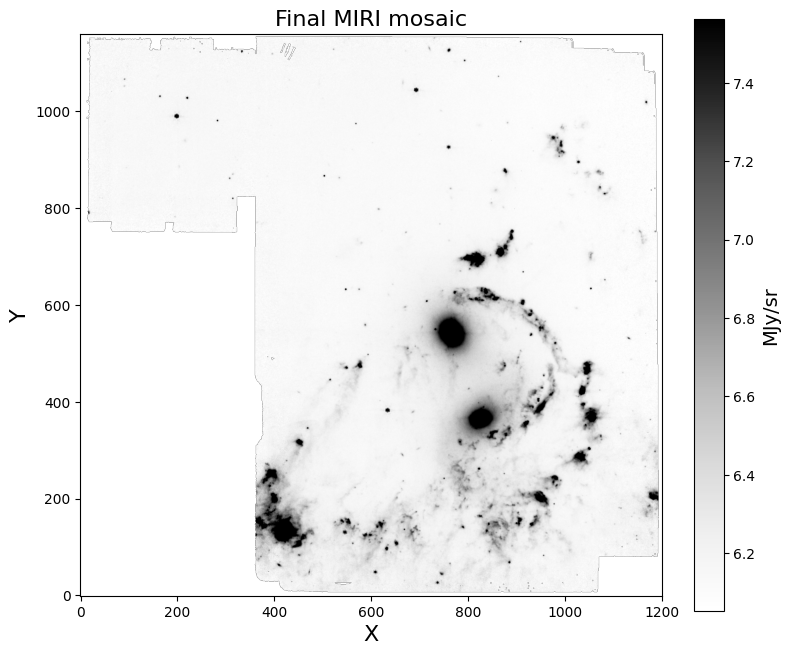

In [30]:
if doviz:
    # Look at the final i2d image (combined mosaic)
    sstring = os.path.join(image3_dir, '*i2d.fits')
    miri_mosaic_file = glob.glob(sstring)
    print(miri_mosaic_file)

    # Read your mosaic image into an ImageModel datamodel
    miri_mosaic = ImageModel(miri_mosaic_file[0])
    
    # Autoscale the stretch
    display_vals = [np.nanpercentile(miri_mosaic.data, 1), np.nanpercentile(miri_mosaic.data, 99)]

    plt.figure(figsize=(8, 8))

    fig, ax = plt.subplots(figsize=(8, 8))

    # Set up image
    cax = ax.imshow(miri_mosaic.data, cmap='Greys', origin='lower', vmin=display_vals[0], vmax=display_vals[1])

    # Set up colorbar
    cb = fig.colorbar(cax, fraction=0.046)
    cb.ax.set_ylabel('MJy/sr', fontsize=14)

    # Set labels 
    ax.set_xlabel('X', fontsize=16)
    ax.set_ylabel('Y', fontsize=16)
    ax.set_title('Final MIRI mosaic', fontsize=16)
    plt.tight_layout()

In [31]:
display_vals

[np.float32(6.0530257), np.float32(7.563012)]

<hr style="border:1px solid gray"> </hr>

In [32]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 321 seconds
